In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda:0')  # используй первую GPU (номеруются с нуля)

X = torch.randn(5, 100, device=device)  # создай матрицу на этом устройстве
# альтернативно: X = X.to(device)

# создадим какую-нибудь модель
model = nn.Sequential(
    nn.Linear(100, 20),
    nn.ReLU(),
    nn.Linear(20, 8)
)

model = model.to(device)  # переведи параметры модели на это устройство

model(X)

tensor([[ 0.3204,  0.1854, -0.2118, -0.3127,  0.1647, -0.0595, -0.0642, -0.0299],
        [ 0.5889,  0.1756, -0.1661, -0.1191, -0.0854,  0.1189, -0.0502, -0.1986],
        [ 0.3930,  0.2702,  0.1948,  0.2302, -0.0322, -0.1218,  0.3561, -0.1162],
        [-0.0851,  0.3130,  0.1885, -0.2412, -0.0321,  0.0118,  0.6537, -0.4645],
        [ 0.1751,  0.3124,  0.0724, -0.0110, -0.0681,  0.2481, -0.2146,  0.1210]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2022-03-28 16:53:42--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar.4’

universum_compresse 100%[===================>]  68.69M  5.11MB/s    in 15s     

2022-03-28 16:53:57 (4.49 MB/s) - ‘universum_compressed.tar.4’ saved [72028160/72028160]



In [ ]:
# tqdm -- это маленькая библиотечка для прорисовывания progress bar-ов прямо в питоне

from tqdm import tqdm
from time import sleep

for i in tqdm(range(10)):
    sleep(0.5)

100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


In [ ]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

In [ ]:
transform_all = transforms.Compose([
    # вырежем случайный квадратик
    transforms.RandomResizedCrop(128),
    # горизонтально перевернем -- изображение останется валидным
    transforms.RandomHorizontalFlip(),
    # что бы ещё поделать, чтобы увеличить размер датасета?
    # ...
    transforms.ToTensor(),
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)
    # минутка эволюционной биологии: как вы думаете, почему коэффициенты именно такие?

In [ ]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 715.93it/s]


In [ ]:
def Block(channels_in, channels_out):
    n = 512
    return nn.Sequential(
        nn.BatchNorm2d(channels_in),
        nn.Conv2d(channels_in, channels_in, (3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(channels_in),
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(channels_out),
        nn.Conv2d(channels_out, channels_out, (3, 3), padding=1),
        nn.ReLU(),
        #nn.MaxPool2d(),
        #nn.Dropout(),
        #nn.BatchNorm2d(channels_out),
    )



In [ ]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
          Block(1, 64),
          nn.MaxPool2d((2, 2)),
          Block(64, 128),
          nn.MaxPool2d((2, 2)),
          Block(128, 256),
          Block(256, 256),
          Block(256, 256),
          Block(256, 256),
          Block(256, 256),
          nn.Upsample(scale_factor=2),
          Block(256, 128),
          nn.Upsample(scale_factor=2),
          Block(128, 64),
        )
         
        self.postconcat = nn.Sequential(         # эту сетку можно особо не увеличивать - она не должна быть очень умной
            nn.Conv2d(65, 32, (3, 3), padding=1),# подумайте, откуда у автора тут 65
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        # исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [ ]:
'''
          Block(128, 256),
          Block(256, 512),
          Block(512, 512),
          Block(512, 1024),
          Block(1024, 1024),
          Block(1024, 512),
          Block(512, 512),
          Block(512, 256),
'''

'\n          Block(128, 256),\n          Block(256, 512),\n          Block(512, 512),\n          Block(512, 1024),\n          Block(1024, 1024),\n          Block(1024, 512),\n          Block(512, 512),\n          Block(512, 256),\n'

In [ ]:
num_epochs = 100
lr = 1e-3

model = Colorizer().to(device)

#clipping_value = 0.5 # arbitrary value of your choosing
#torch.nn.utils.clip_grad_norm(model.parameters(), clipping_value)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()  # тут можно поиграться с лоссами

In [ ]:
def to_numpy_image(img):
    # tl;dr: PyTorch хочет (3, 128, 128), а plt.imshow хочет (128, 128, 3)
    # есть два популярных формата для цветных картинок:
    #  1. где размерность, соответствующая каналам, идёт последней
    #  2. где размерность, соответствующая каналам, идёт первой
    # при работе с нейросетями удобен первый подход -- так запрашиваемая
    # при вычислениях память идёт последовательно, и из-за кэширования
    # операции свёртки работают быстрее
    # второй подход удобнее при уже работе с устройством, которое эти картинки показывает
    # -- удобно на три лампочки послать сразу три последовательно идущих байта
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

In [ ]:
history = []
for epoch in range(num_epochs):
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      pred = model(x)
      loss = criterion(pred, y)
      history.append(loss.item())
      loss.backward()
      optimizer.step()
      for t in range(350, 353):
          img_gray, img_true = dataset[t]
          img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
          img_pred = to_numpy_image(img_pred)
          # теперь это numpy-евский ndarray размера (128, 128, 3)
          plt.figure(figsize=(10,10))
          
          plt.subplot(141)
          plt.axis('off')
          plt.set_cmap('Greys')
          plt.imshow(img_gray.reshape((128, 128)))

          plt.subplot(142)
          plt.axis('off')
          plt.imshow(img_pred.reshape((128, 128, 3)))

          plt.subplot(143)
          plt.axis('off')
          plt.imshow(to_numpy_image(img_true))
          
          plt.show()
      print(history[-1])
        # теперь сами:
        # 0. распакавать данные на нужное устройство
        # 1. сбросить градиент
        # 2. прогнать данные через сеть
        # 3. посчитать loss
        # 4. залоггировать его куда-нибудь
        # 5. сделать .backward()
        # 6. optimizer.step()
        # (7. вывести пример колоризации -- см код ниже)

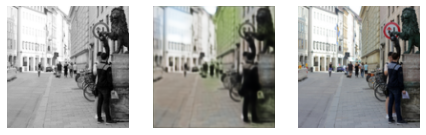

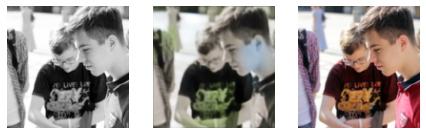

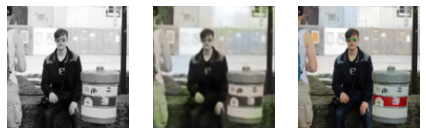

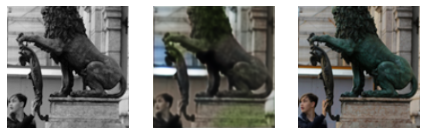

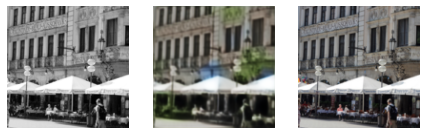

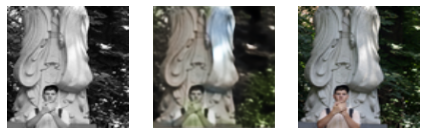

0.045989666134119034


In [ ]:
for t in range(350, 356):
    img_gray, img_true = dataset[t]
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    # теперь это numpy-евский ndarray размера (128, 128, 3)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141) 
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()
print(history[-1])